In [142]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's define a function f

In [143]:
def f(x):
    return 3*x**2 - 4*x + 5

In [144]:
f(3.0)

20.0

We can also plot it for a range of values

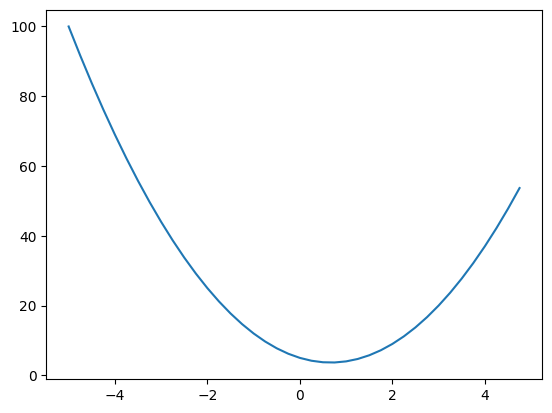

In [145]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now, what's a derivate?
> It is sensitivity of the function to the change of the output with respect to the input.

In simpler terms, (f(x+h) - f(x))/h, where h tends to zero. This gives us the slope.

In [146]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

Let's define a function with mupltiple inputs

In [147]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [148]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to a), we know that this will be b

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [149]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to b), we know that this will be a

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [150]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to c), we know that this will be 1

d1 4.0
d2 4.0001
slope 0.9999999999976694


The NN will be mathematically very large expressions. We now start by building the data structures for this. Let's start by making the `Value` object from mircograd

In [167]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # Define a empty tuple `children` to keep the pointers of other Value objects
                                                             # Define a empty set `op` to keep track of what created that Value object
        self.data = data
        self.grad = 0.0 # this is the derivative of Value wrt to its nodes; initalized as 0 (we assume at the beginning that every Value doesn't impact the output)
        self._backward = lambda: None # for a leaf node, this should be nothing.
        self._prev = set(_children) # This will be a empty set when we define a new Value object (a, b, c)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other): # a.__add__(b)
        other = other if isinstance(other, Value) else Value(other) # if other is NOT a Value obj, just make one
        out = Value(self.data + other.data, (self, other), '+') # Since self.data and other.data is python floating point number,
                                                                # the addition is according to whatever is defined in the python kernel
        def _backward():
            self.grad +=  1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other): # a.__mul__(b) # You can't name it mult or multi, because we are defining magic methods for the Value object
        other = other if isinstance(other, Value) else Value(other) # if other is NOT a Value obj, just make one
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)) # other is only int or float
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self*other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self, other):
        assert isinstance(other, (float, int))
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

In [152]:
# imported from mircograd's codebase

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Let's look at another backpropagation using a neuron

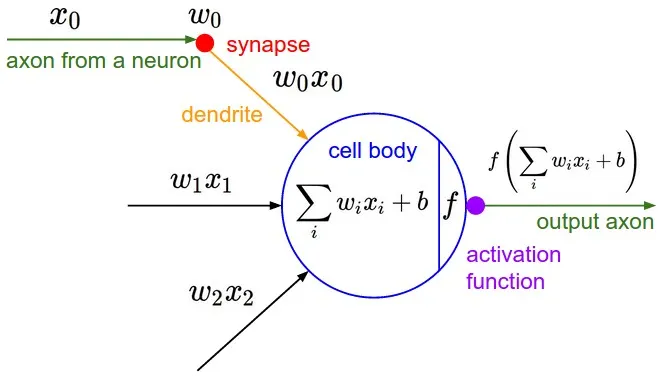

activation function is usually sigmoid or tanh [[more here]](https://en.wikipedia.org/wiki/Activation_function)

In [153]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'
o.backward()

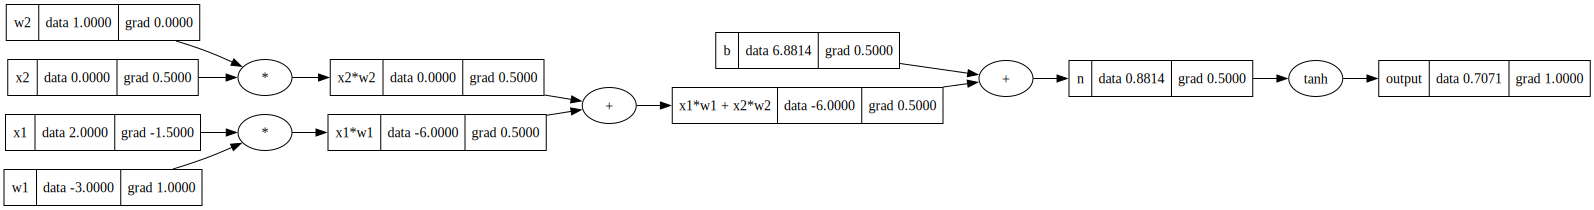

In [154]:
draw_dot(o)

In [155]:
a = Value(2.0)
a + 1

Value(data=3.0)

Let's add this QoL improvement.

In [156]:
print(a * 2)
print(2 * a)

Value(data=4.0)
Value(data=4.0)


In [157]:
a = Value(4.0)
a.exp()

Value(data=54.598150033144236)

a / b
a * 1/b
a * b**-1

so, let's implement n**k and have a spl case for division

In [158]:
z = Value(5.0)
z**3

Value(data=125.0)

In [159]:
a = Value(4.0)
b = Value(8.0)
a / b

Value(data=0.5)

In [160]:
a = Value(4.0)
b = Value(8.0)
a - b

Value(data=-4.0)

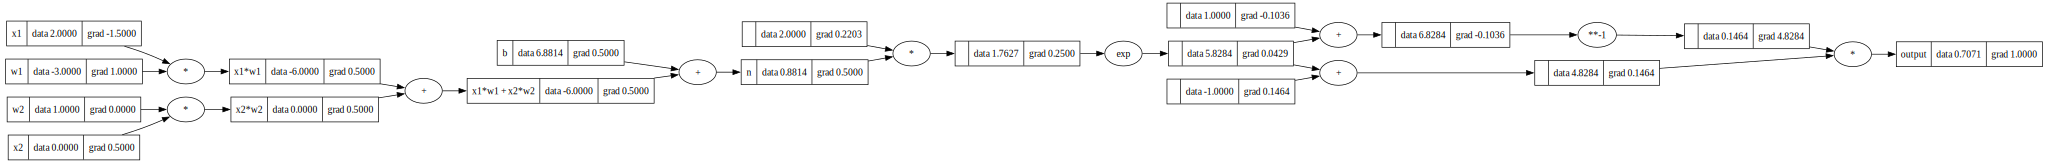

In [161]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# Let's define tanh using exp and divide and subtract
e = (2*n).exp()
o = (e - 1) / (e + 1) 
#---
o.label = 'output'
o.backward()
draw_dot(o)

Now let's look at the same thing in pytorch

In [162]:
import torch

In [163]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # This is false by default because no one needs to see gradients on the input layer
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Let's now build the a neural net library (multi-layer perceptron) in mircograd

In [175]:
import random
class Neuron:

    def __init__(self, nin): # nin is number of inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout): # nin is the number of inputs on each neuron, nout is the number of neurons in the layer
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs # QoL 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neurons.parameters()
        #     params.extend(ps)
        # return params

class MLP:

    def __init__(self, nin, nouts): # nout is the list of the numbers of neurons in each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# x = [2.0, 3.0,]
# n = Layer(2, 3) # three 2-dimensional neutrons in this Layer
# n(x)

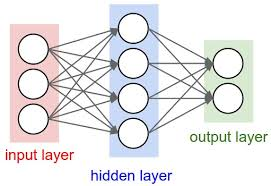

Now let's define a layer and a MLP (multi-layer perceptron)

Let's train a NN! (finally!) This is a simple binary classifer NN

In [240]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1]) # implementing the example image
n(x)

Value(data=0.5295324547878887)

In [184]:
len(n.parameters())

41

In [177]:
# when we feed the first inputs, we should get the first output (1.0) and so on.

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.07700064719309661),
 Value(data=0.6874724332729629),
 Value(data=-0.7191542943909137),
 Value(data=-0.12016611563222777)]

We want `ypred` to go as close to as `ys`. We do this (and in deep learning) by calculating a single number for perfomance called the *loss*. We are going to implement a mean-square loss

In [178]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.033137455307795)

In [179]:
loss.backward()

In [180]:
n.layers[0].neurons[0].w[0].grad # this is now NOT zero!

0.7368026977666375

In [185]:
n.layers[0].neurons[0].w[0].data

-0.32973208920024066

In [187]:
for p in n.parameters():
    p.data += -0.01 * p.grad # negative sign because we want to minimise the loss. We think of grad as a vector pointing towards increased loss. This is gradient descent.
                             # https://en.wikipedia.org/wiki/Gradient_descent#An_analogy_for_understanding_gradient_descent

Let's look at the new loss (It has decreased)

In [189]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.7015356808242585)

Let backprop this loss and update the weights

In [190]:
loss.backward()

In [191]:
for p in n.parameters():
    p.data += -0.01 * p.grad # negative sign because we want to minimise the loss. We think of grad as a vector pointing towards increased loss. This is gradient descent.
                             # https://en.wikipedia.org/wiki/Gradient_descent#An_analogy_for_understanding_gradient_descent

Now let's find the new loss

In [192]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.193172494954373)

So the flow is forward pass -> backward pass -> update

In [241]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ls = []

for k in range(500):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # YOU NEED TO clear out your gradient before every backward pass or it will just accumulate
    loss.backward()

    # update (the gradient descent)
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print('Step #', k, ' ', loss.data)
    ls += [loss.data]

Step # 0   6.063052689312497
Step # 1   3.4913909241492496
Step # 2   1.2084297159180784
Step # 3   0.4656671369410741
Step # 4   0.24785984660117516
Step # 5   0.17205836536367008
Step # 6   0.13140359668124182
Step # 7   0.10607370364195885
Step # 8   0.08881662744244229
Step # 9   0.07632247962333527
Step # 10   0.06686857143197884
Step # 11   0.05947134159212191
Step # 12   0.05352900687658706
Step # 13   0.04865302737738714
Step # 14   0.04458150502268218
Step # 15   0.04113156601356174
Step # 16   0.03817169980897338
Step # 17   0.03560494239910917
Step # 18   0.0333582524439753
Step # 19   0.031375575848589486
Step # 20   0.02961318784557092
Step # 21   0.028036486100278167
Step # 22   0.026617733994873168
Step # 23   0.025334441397667242
Step # 24   0.024168182466436462
Step # 25   0.023103718921689623
Step # 26   0.022128340591535754
Step # 27   0.021231362959825167
Step # 28   0.020403739813356792
Step # 29   0.01963776138740571
Step # 30   0.0189268167944545
Step # 31   0.01

In [245]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9868926891382584),
 Value(data=-0.9822284602914287),
 Value(data=-0.9834981983414189),
 Value(data=0.9831334891456814)]

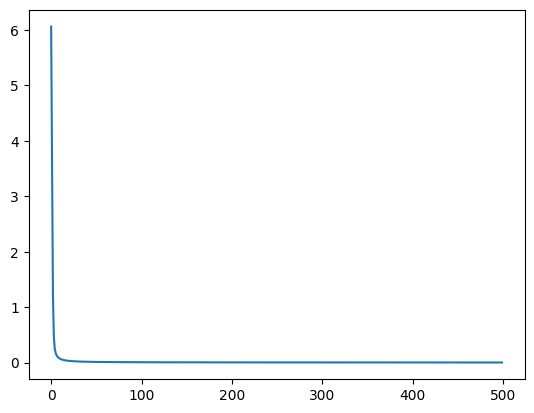

In [246]:
plt.plot(np.arange(0, 500, 1), ls)